In [2]:
from sdia import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

### Notes

This notebook will be devoted to trying out algorithms for non-negative regression on spectra. Most of the spectral processing will be a recapitulation of the analyze function from the SpectralAnalyzer class. I will keep all of that up front so that I can spend the bulk of the notebook on analysis functions.

### Spectral Loading

In [3]:
filename = "../Data/DIA_FULL/UWPROFL0362.mzML"
file = MzMLFile()
exp = MSExperiment()
file.load(filename, exp)

In [4]:
spec = SpectralAnalyzer(lib_path="../Data/spectral_library/",
                        lib_name="filtered_silac_library_b&y",
                        ppm_tol=5., lam=1e8, is_silac=True)

In [5]:
def get_frame_data(frame_ind):
    frame = exp[frame_ind]
    
    # Extract spectra
    mz, intensity = spec.extract_spectra(frame)
        
    # Filter libraries
    retention_range = frame.getRT() + 60 * 5. * np.array([-1., 1.])
    precursor = frame.getPrecursors()[0]
    mass_range = precursor.getMZ() + precursor.getIsolationWindowLowerOffset() * np.array([-1. , 1.])
    filtered_lib = spec.lib.get_range(retention_range, mass_range)
    filtered_decoys = spec.decoys.get_range(retention_range, mass_range)
        
    # Filter peaks
    filtered_lib, lib_bins = spec.bin_peaks(mz, filtered_lib)
    filtered_decoys, decoy_bins = spec.bin_peaks(mz, filtered_decoys)
        
    if filtered_lib.shape[0] == 0:
        return None, None
        
    # Build columns
    if spec.is_silac:
        idx = filtered_lib.isotope.values
        decoy_idx = filtered_decoys.isotope.values
    else:
        idx = filtered_lib.index.values
        decoy_idx = filtered_decoys.index.values
            
    unique_idx, first_idx = np.unique(idx, return_index=True)
    unique_decoy_idx, decoy_first_idx = np.unique(decoy_idx, return_index=True)
        
    mapping_dict = {old: new for new, old in enumerate(unique_idx)}
    col_idx = np.array([mapping_dict[ind] for ind in idx], dtype=np.int64)
        
    decoy_mapping_dict = {old: new for new, old in enumerate(unique_decoy_idx)}
    offset = col_idx.max() + 1
    decoy_col_idx = np.array([decoy_mapping_dict[ind] + offset for ind in decoy_idx], dtype=np.int64)
        
    concat_cols = np.concatenate([col_idx, decoy_col_idx])
        
    # Build rows
    unique_bins = np.unique(np.concatenate([lib_bins, decoy_bins]))
    mapping_dict = {old: new for new, old in enumerate(unique_bins)}

    row_idx = np.array([mapping_dict[ind] for ind in lib_bins])
    decoy_row_idx = np.array([mapping_dict[ind] for ind in decoy_bins], dtype=np.int64)
        
    concat_rows = np.concatenate([row_idx, decoy_row_idx])
        
    # Build matrices
    sparse_library = csc_matrix((np.concatenate([filtered_lib.intensity.values.flatten(),
                                                 filtered_decoys.intensity.values.flatten()]), 
                                 (concat_rows, concat_cols)),
                                shape=(concat_rows.max() + 1, concat_cols.max() + 1))
    regression_library = sparse_library.todense()
    target = intensity[unique_bins]
    
    # Create groups
    if spec.is_silac:
        group_idx = filtered_lib.index.values[first_idx]
        decoy_group_idx = filtered_decoys.index.values[decoy_first_idx]
        
        unique_group = np.unique(group_idx)
        group_map = {old: new for new, old in enumerate(unique_group)}
        groups = np.array([group_map[pep] for pep in group_idx], dtype=np.int64)
        
        unique_decoy_group = np.unique(decoy_group_idx)
        offset = len(unique_group)
        decoy_group_map = {old: new + offset for new, old in enumerate(unique_decoy_group)}
        groups = np.concatenate([groups, 
                                 np.array([decoy_group_map[pep] for pep in decoy_group_idx], 
                                          dtype=np.int64)])
        return regression_library, target, groups
    
    else:
        return regression_library, target

In [6]:
%%time
X, y, g = get_frame_data(30060)

CPU times: user 21 ms, sys: 2 ms, total: 23 ms
Wall time: 22.4 ms


### Implementation: Subgradient method

The objective is given by the following,

$$
\min_{\beta \in \mathbb{R}^+} \Big( 
\| \mathbf{y} - \sum_{l=1}^L \mathbf{X}_l \beta_l \|_2^2 +
\lambda_1 \sum_{l=1}^L \| \beta_l \|_2 +
\lambda_2 \| \beta \|_1  
\Big)
$$

with the subgradients being given by,

$$
\frac{\partial}{\partial \beta_{l,j}} Objective =
- \textbf{X}_{l,j}^T (\textbf{r} - \textbf{X}_{l,j} \beta_{l,j}) +
\lambda_1 s_{l,j} +
\lambda_2 t_{l,j} =
0
$$

$$ s_{l,j} =  
\begin{cases} 
      \frac{\beta_{l,j}}{\|\beta\|_2} & \beta \neq 0 \\
      \textbf{s} \in \mathbb{R}^k \quad s.t. \quad 
      \| \textbf{s} \|_2 \leq 1 & \beta = 0
   \end{cases}
\quad \quad
t_{l,j} =  
\begin{cases} 
      sign(\beta_{l,j}) & \beta_{l,j} \neq 0 \\
      t_{l,j} \in [-1, 1] & \beta_{l,j} = 0
   \end{cases}
$$

The nice part about the group lasso part of the penalty is that it is only non-differentiable when the entirety of the group is zero. So, the subgradient method here will consist of a two part treatment,

**Group Lasso Procedure**

* When $\beta_l > 0$, take the standard gradient of the objective

* When $\beta_l = 0$, take the gradient with respect to $\beta_l$ of the square loss but allow the update to be given by,

$$ \frac{\min \{ \| \nabla_{\beta_l} \|_2 - \lambda_1, 0 \}}{\| \nabla_{\beta_l} \|_2} \nabla_{\beta_l}$$

Basically, the intuition here is that we are only interested in updating $\beta_l$ if it will not eventualy arrive back at 0. This is a legal subgradient at $\beta_l = 0$ and so can be used.

**Sparse Group Lasso Procedure**

* When $\beta_{l,k} > 0$ for every peptide in the group, take the standard gradient of the objective

* When individual $\beta_{l,k} = 0$ take the gradient with respect to $\beta_{l,k}$ of the square loss and the group penalty but allow the update to be given by,

$$ \frac{\min \{ | \nabla_{\beta_{l,k}} | - \lambda_2, 0 \}}{| \nabla_{\beta_{l,k}} |} \nabla_{\beta_{l,k}}$$

* When $\beta_l = 0$, take the gradient with respect to $\beta_l$ of the square loss but allow the update to be given by a two step procedure,

    1. $$  \nabla_{\beta_l}' = 
           \frac{\min \{ \| \nabla_{\beta_l} \|_2 - \lambda_1, 0 \}}{\| \nabla_{\beta_l} \|_2} \nabla_{\beta_l}
       $$
    2. $$ 
          \frac{\min \{ | \nabla_{\beta_{l},k}' | - \lambda_2, 0 \}}{| \nabla_{\beta_{l},k}'  |} \nabla_{\beta_{l},k}'
       $$
       
The two step procedure gives the group penalty the ability to act first, but gives a second penalty on to the components of any group which passes the threshold.

In [7]:
class GradGL:
    def __init__(self, l2_penalty, step_size=5e-10, max_iter=100):

        self.l2_penalty = l2_penalty
        self.step_size = step_size
        self.max_iter = max_iter
        self.X_ = None
        self.y_ = None
        self.group_map_ = None
        self.coef_ = None
        self.loss_ = None
        
    def preprocess_groups(self, groups):
        idx = np.arange(len(groups))
        group_map = {g: idx[groups == g] for g in np.unique(groups)}
        return group_map
    
    def calculate_loss(self):
        loss = np.sum(np.power(self.y_ - np.matmul(self.X_, self.coef_), 2))
        for g in self.groups_:
            group_select = self.groups_[g]
            group_size = len(group_select)
            group_norm = np.linalg.norm(self.coef_[group_select])
            loss += self.l2_penalty * np.sqrt(group_size) * group_norm
            
        return loss
        
    def fit(self, X, groups, y):
        # Store groups
        self.groups_ = self.preprocess_groups(groups)
        
        # Check X and y
        self.X_, self.y_ = X, np.atleast_2d(y).T

        # Set coefficients to zero
        self.coef_ = 10 * np.abs(np.random.randn(self.X_.shape[1], 1)) #np.zeros([self.X_.shape[1], 1])
        best_loss = np.inf
        best_coef = None
        tracker = 2
        for i in range(self.max_iter):
            cur_loss = self.calculate_loss()
            if cur_loss < best_loss:
                best_loss = cur_loss
                best_coef = self.coef_.copy()
                tracker = 2
            else:
                tracker -= 1
                if tracker == 0:
                    break
            
            loss_grad = -1. * np.matmul(X.T, (self.y_ - np.matmul(self.X_, self.coef_)))
            
            for g in self.groups_:
                group_select = self.groups_[g]
                group_size = len(group_select)
                if np.any(self.coef_[group_select] > 0.):
                    penalty_grad = self.coef_[self.groups_[g]] / np.linalg.norm(self.coef_[self.groups_[g]])
                    loss_grad[group_select] += self.l2_penalty * np.sqrt(group_size) * penalty_grad
                else:
                    grad_norm = np.linalg.norm(loss_grad[group_select])
                    grad_scale = max(grad_norm - self.l2_penalty * np.sqrt(group_size), 0.) / grad_norm
                    loss_grad[group_select] = grad_scale * loss_grad[group_select]
                    
            self.coef_ -= self.step_size * loss_grad
            self.coef_ = np.maximum(self.coef_, 0.)
            
        self.coef_ = best_coef.copy()
        self.loss_ = best_loss
        
    def predict(self):
        return np.matmul(self.X_, self.coef_) 
                              

In [8]:
%%time
model = GradGL(l2_penalty=1e10, max_iter=1000, step_size=5e-10)
model.fit(X, g, y)

CPU times: user 144 ms, sys: 1 ms, total: 145 ms
Wall time: 148 ms


In [9]:
for i in range(len(g)):
    print(g[i], model.coef_[i])

0 [0.]
1 [0.]
2 [0.]
3 [0.]
3 [0.]
4 [0.]
5 [0.]
6 [0.]
6 [0.]
7 [0.]
8 [0.]
9 [0.]
9 [0.]
10 [0.]
11 [0.]
12 [0.]
13 [0.]
14 [0.]
15 [0.]
16 [0.]
16 [0.]
17 [0.]
18 [0.]
18 [0.]
19 [0.]
20 [313.6376919]
20 [297.53250139]
21 [0.]
22 [0.]
22 [0.]
23 [0.]
24 [0.]
25 [0.]
26 [0.]
26 [0.]
27 [0.]
28 [0.]
29 [0.]
29 [0.]
30 [58.24439465]
30 [0.]
31 [0.]
31 [0.]
32 [0.]
33 [0.]


(175, 1)


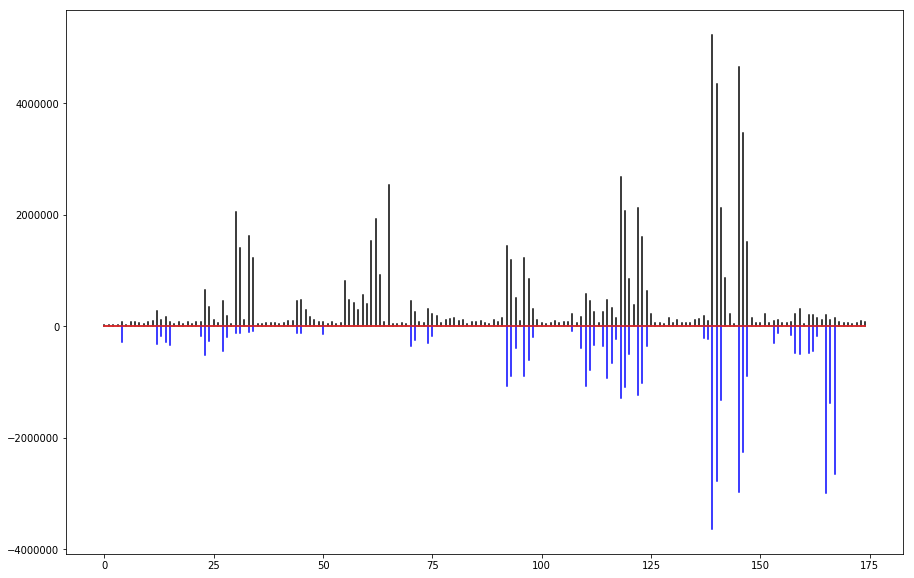

In [10]:
plt.figure(figsize=(15, 10))
true_y = model.y_.flatten()
plt.stem(np.arange(len(true_y)), true_y, 
        markerfmt=" ",  linefmt="black")

pred_y = -model.predict()[:, 0]
print(pred_y.shape)
plt.stem(np.arange(len(pred_y)), pred_y, 
        markerfmt=" ",  linefmt="blue")
plt.show()

In [156]:
class GradSGL:
    def __init__(self, l2_penalty, l1_penalty, step_size=5e-10, max_iter=100):

        self.l2_penalty = l2_penalty
        self.l1_penalty = l1_penalty
        self.step_size = step_size
        self.max_iter = max_iter
        self.X_ = None
        self.y_ = None
        self.group_map_ = None
        self.coef_ = None
        self.loss_ = None
        
    def preprocess_groups(self, groups):
        idx = np.arange(len(groups))
        group_map = {g: idx[groups == g] for g in np.unique(groups)}
        return group_map
    
    def calculate_loss(self):
        loss = np.sum(np.power(self.y_ - np.matmul(self.X_, self.coef_), 2))
        for g in self.groups_:
            group_select = self.groups_[g]
            group_size = len(group_select)
            group_norm = np.linalg.norm(self.coef_[group_select])
            loss += self.l2_penalty * np.sqrt(group_size) * group_norm
        loss += self.l1_penalty * np.sum(self.coef_)
            
        return loss
        
    def fit(self, X, groups, y):
        # Store groups
        self.groups_ = self.preprocess_groups(groups)
        
        # Check X and y
        self.X_, self.y_ = X, np.atleast_2d(y).T

        # Set coefficients to zero
        self.coef_ = 10 * np.abs(np.random.randn(self.X_.shape[1], 1)) #np.zeros([self.X_.shape[1], 1])
        best_loss = np.inf
        best_coef = None
        tracker = 2
        for i in range(self.max_iter):
            cur_loss = self.calculate_loss()
            if cur_loss < best_loss:
                best_loss = cur_loss
                best_coef = self.coef_.copy()
                tracker = 2
            else:
                tracker -= 1
                if tracker == 0:
                    break
            
            loss_grad = -1. * np.matmul(X.T, (self.y_ - np.matmul(self.X_, self.coef_)))
            
            for g in self.groups_:
                group_select = self.groups_[g]
                group_size = len(group_select)
                if np.any(self.coef_[group_select] > 0.):
                    penalty_grad = self.coef_[self.groups_[g]] / np.linalg.norm(self.coef_[self.groups_[g]])
                    loss_grad[group_select] += self.l2_penalty * np.sqrt(group_size) * penalty_grad
                else:
                    grad_norm = np.linalg.norm(loss_grad[group_select])
                    grad_scale = max(grad_norm - self.l2_penalty * np.sqrt(group_size), 0.) / grad_norm
                    loss_grad[group_select] = grad_scale * loss_grad[group_select]
            
            # l1 penalty
            coef_zero = self.coef_ == 0
            grad_zero = loss_grad == 0
            defined = np.array(np.logical_and(~coef_zero, ~grad_zero)).flatten()
            if np.any(defined):
                signs = np.sign(self.coef_[defined])
                loss_grad[defined] += signs * self.l1_penalty
                
            undefined = np.array(np.logical_and(coef_zero, ~grad_zero)).flatten()
            if np.any(undefined):
                zero_pos = np.array(loss_grad[undefined])
                scale = np.maximum(np.abs(zero_pos) - self.l1_penalty, 0.) / np.abs(zero_pos)
                loss_grad[undefined] = scale * zero_pos
                    
            self.coef_ -= self.step_size * loss_grad
            self.coef_ = np.maximum(self.coef_, 0.)
            
        self.coef_ = best_coef.copy()
        self.loss_ = best_loss
        
    def predict(self):
        return np.matmul(self.X_, self.coef_) 

In [165]:
%%time
model = GradSGL(l2_penalty=1e10, l1_penalty=1e10, max_iter=1000, step_size=5e-10)
model.fit(X, g, y)

CPU times: user 901 ms, sys: 2 ms, total: 903 ms
Wall time: 909 ms


In [166]:
for i in range(len(g)):
    print(g[i], model.coef_[i])

0 [0.]
1 [0.]
2 [0.]
3 [0.]
3 [0.]
4 [0.]
5 [0.]
6 [0.]
6 [0.]
7 [0.]
8 [0.]
9 [0.]
9 [0.]
10 [0.]
11 [0.]
12 [0.]
13 [0.]
14 [0.]
15 [0.]
16 [0.]
16 [0.]
17 [0.]
18 [0.]
18 [0.]
19 [0.]
20 [301.63990363]
20 [269.22419677]
21 [0.]
22 [0.]
22 [0.]
23 [0.]
24 [0.]
25 [0.]
26 [0.]
26 [0.]
27 [0.]
28 [0.]
29 [0.]
29 [0.]
30 [0.]
30 [0.]
31 [0.]
31 [0.]
32 [0.]
33 [0.]
